In [139]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm
import multiprocessing
import seaborn as sns
import warnings

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood

## Initial

Sample 10 realisations using fixed seed for seed sequence and check sampling/convergence/mixing and find way to plot

In [402]:
np.random.SeedSequence()

SeedSequence(
    entropy=94210775887672546008100330582776109227,
)

In [5]:
max_T = 100
num_samples = 10
hawkes_realisations = []

master_seed = 240918493712496904598658578838980943694
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

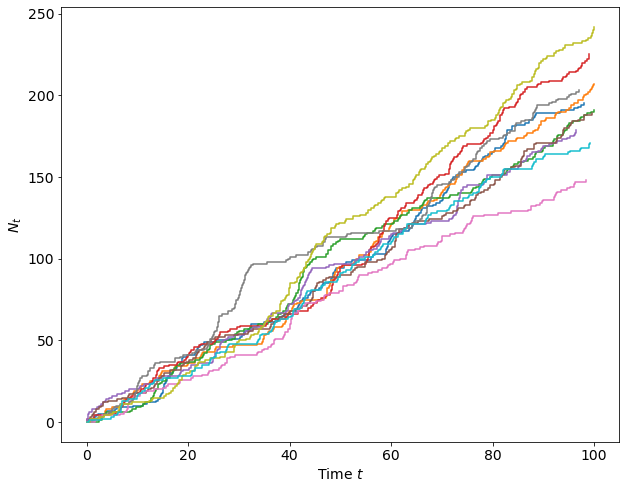

In [6]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [7]:
stan_file = os.path.join('.', 'simple_exp_hawkes_v2.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [8]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

In [9]:
# data = {
#     "N" : N,
#     "events_list" : hawkes_realisation,
#     "max_T" : max_T
# }

In [10]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [36]:
inits = {"mu": 0.5, "alpha": 0.5, "delta": 0.5}

Quick reproducibility check

fit and fit2 with no inits, same seed

fit3 and fit4 with same init, same seed

In [45]:
warmup=250

In [46]:
fit = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            save_warmup=True)

19:33:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:34:10 - cmdstanpy - INFO - CmdStan done processing.


In [47]:
fit2 = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            save_warmup=True)

19:34:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:34:37 - cmdstanpy - INFO - CmdStan done processing.


In [48]:
fit3 = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            save_warmup=True)

19:34:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:35:29 - cmdstanpy - INFO - CmdStan done processing.


In [49]:
fit4 = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            save_warmup=True)

19:35:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:37:00 - cmdstanpy - INFO - CmdStan done processing.


In [50]:
fit.summary() == fit2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,True,True,True,True,True,True,True,False,True
mu,True,True,True,True,True,True,True,False,True
alpha,True,True,True,True,True,True,True,False,True
delta,True,True,True,True,True,True,True,False,True
hawkes_log_likelihood,True,True,True,True,True,True,True,False,True


In [51]:
fit.summary() == fit3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,False,False,False,False,False,False,False,False,False
mu,False,False,False,False,False,False,False,False,False
alpha,False,False,False,False,False,False,False,False,False
delta,False,False,False,False,False,False,False,False,False
hawkes_log_likelihood,False,False,False,False,False,False,False,False,False


In [52]:
fit3.summary() == fit4.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,True,True,True,True,True,True,True,False,True
mu,True,True,True,True,True,True,True,False,True
alpha,True,True,True,True,True,True,True,False,True
delta,True,True,True,True,True,True,True,False,True
hawkes_log_likelihood,True,True,True,True,True,True,True,False,True


In [54]:
np.all(fit.draws_pd() == fit2.draws_pd())

True

In [55]:
np.all(fit.draws_pd() == fit3.draws_pd())

False

In [56]:
np.all(fit3.draws_pd() == fit4.draws_pd())

True

In [59]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-43.185700,0.052456,1.321330,-45.817200,-42.804600,-41.74840,634.512,16.7772,0.999924
mu,0.971408,0.006127,0.179040,0.680371,0.963281,1.25798,853.795,22.5752,1.001840
alpha,1.080780,0.009821,0.249439,0.704764,1.065150,1.51418,645.110,17.0574,0.999601
delta,2.153870,0.019857,0.486237,1.410360,2.128490,3.01933,599.606,15.8542,0.999749
hawkes_log_likelihood,-43.796800,0.047108,1.191100,-46.127800,-43.485300,-42.51290,639.294,16.9036,0.999633


In [60]:
fit3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-43.118900,0.052806,1.280470,-45.529400,-42.800500,-41.74270,587.992,6.69924,1.001340
mu,0.962136,0.006842,0.174369,0.673417,0.965174,1.25945,649.456,7.39952,0.999287
alpha,1.061120,0.010384,0.255267,0.666645,1.051710,1.47967,604.315,6.88521,1.000680
delta,2.082920,0.021391,0.487340,1.345060,2.050390,2.90393,519.061,5.91388,1.000680
hawkes_log_likelihood,-43.681800,0.043338,1.106290,-45.753300,-43.410300,-42.48540,651.636,7.42436,0.999729


Inits check

In [62]:
inits = {"mu": 0.5, "alpha": -0.5, "delta": -0.5}
fit = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            save_warmup=True)

19:58:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:58:06 - cmdstanpy - ERROR - CmdStan error: error during processing Operation not permitted


19:58:06 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: lb_free: Lower bounded variable is -0.5, but must be greater than or equal to 0.000000 (in 'simple_exp_hawkes_v2.stan', line 54, column 4 to column 24)
Command and output files:
RunSet: chains=2, chain_ids=[1, 2], num_processes=1
 cmd (chain 1):
	['C:\\Users\\ethan\\OneDrive - University of Bristol\\Maths\\Year 4\\Project\\hawkes_project\\simple_exp_hawkes_v2.exe', 'id=1', 'random', 'seed=123', 'data', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\g5q671pq.json', 'init=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\v1yslih8.json', 'output', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\simple_exp_hawkes_v21au5fmve\\simple_exp_hawkes_v2-20240420195806.csv', 'method=sample', 'num_samples=750', 'num_warmup=250', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=2']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v21au5fmve\simple_exp_hawkes_v2-20240420195806_1.csv
 console_msgs (if any):
	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v21au5fmve\simple_exp_hawkes_v2-20240420195806-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

Cannot violate declared constraints.

In [64]:
inits = {"mu": 0.5, "alpha": 0.5, "delta": 0}
fit = model_compiled.sample(data=data_list[0],
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits=inits,
                            save_warmup=True)

19:58:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:58:45 - cmdstanpy - ERROR - CmdStan error: error during processing Operation not permitted


19:58:45 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:

Command and output files:
RunSet: chains=2, chain_ids=[1, 2], num_processes=1
 cmd (chain 1):
	['C:\\Users\\ethan\\OneDrive - University of Bristol\\Maths\\Year 4\\Project\\hawkes_project\\simple_exp_hawkes_v2.exe', 'id=1', 'random', 'seed=123', 'data', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\sppvyxad.json', 'init=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\dv9j8j32.json', 'output', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpbvmprv8b\\simple_exp_hawkes_v2nbnw3gbq\\simple_exp_hawkes_v2-20240420195845.csv', 'method=sample', 'num_samples=750', 'num_warmup=250', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=2']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v2nbnw3gbq\simple_exp_hawkes_v2-20240420195845_1.csv
 console_msgs (if any):
	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v2nbnw3gbq\simple_exp_hawkes_v2-20240420195845-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

Even on the boundary introduces issues.

In any case, because it initialises randomly on *unconstrained* space, should be OK to not specify inits.

In [11]:
warmup=250

## RAN ONCE AND SAVED TO CSVs - NO NEED TO RUN AGAIN
# master_seed_stan = 274357941447129089762691042348752272039
# seed_seq_master_stan = np.random.SeedSequence(master_seed_stan, pool_size=4)

# fits = []

# for i in range(num_samples):

#     child_seed_stan = seed_seq_master_stan.spawn(1)[0]

#     # Create a random number generator using the seed
#     rng = np.random.default_rng(child_seed_stan)
    
#     # Generate random integers less than 2**32 - 1
#     child_seed = rng.integers(2**32 - 1)
#     print(child_seed)

#     fit = model_compiled.sample(data=data_list[i],
#                                 seed=child_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 save_warmup=True)
#     fits.append(fit)

In [144]:
fits

[CmdStanMCMC: model=simple_exp_hawkes_v2 chains=2['method=sample', 'num_samples=750', 'num_warmup=250', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=2']
  csv_files:
 	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v20eq8gspu\simple_exp_hawkes_v2-20240420201133_1.csv
 	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v20eq8gspu\simple_exp_hawkes_v2-20240420201133_2.csv
  output_files:
 	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v20eq8gspu\simple_exp_hawkes_v2-20240420201133-stdout.txt,
 CmdStanMCMC: model=simple_exp_hawkes_v2 chains=2['method=sample', 'num_samples=750', 'num_warmup=250', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=2']
  csv_files:
 	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v2nm47lzn3\simple_exp_hawkes_v2-20240420201201_1.csv
 	C:\Users\ethan\AppData\Local\Temp\tmpbvmprv8b\simple_exp_hawkes_v2nm47lzn3\simple_exp_hawkes_v2-20240420201201_2.csv
  out

Save runs to csv files using the method provided by CmdStanPy

In [12]:
save_path=r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian\initial"

In [13]:
os.getcwd()

'C:\\Users\\ethan\\OneDrive - University of Bristol\\Maths\\Year 4\\Project\\hawkes_project'

In [14]:
# for i, fit in enumerate(fits):
#     fit.save_csvfiles(os.path.join(save_path, f"fit{i}"))

Do a check - that loading from csv gives same summary and draws data

In [152]:
new_fit0 = cmdstanpy.from_csv(os.path.join(save_path, "fit0"))

In [153]:
fits[0].summary() == new_fit0.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,True,True,True,True,True,True,True,True,True
mu,True,True,True,True,True,True,True,True,True
alpha,True,True,True,True,True,True,True,True,True
delta,True,True,True,True,True,True,True,True,True
hawkes_log_likelihood,True,True,True,True,True,True,True,True,True


In [154]:
np.all(fits[0].draws_pd()==new_fit0.draws_pd())

True

Hooray! It does.

Reload data from csvs:

In [17]:
fits = []

for i in range(num_samples):
    fits.append(cmdstanpy.from_csv(os.path.join(save_path, f"fit{i}")))

In [385]:
def trace_plot(df, param, warmup=None, chains=2):
    for i in range(1, chains+1):
        plt.plot(df[df['chain__']==i][param].values, label=i)
    if warmup:
        plt.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
    plt.legend()
    plt.show()

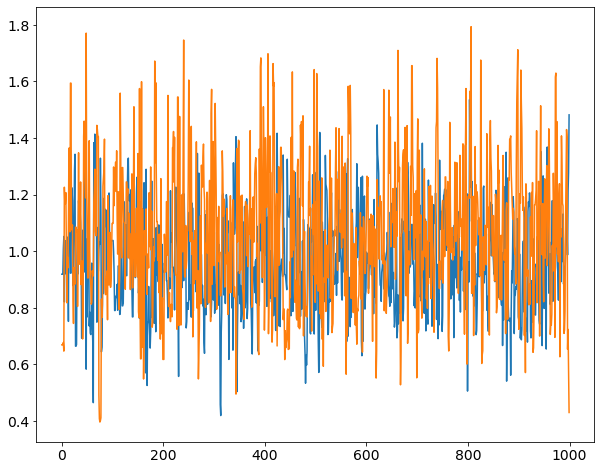

In [386]:
df = fits[0].draws_pd(inc_warmup=True)
plt.plot(df[df['chain__']==1][['mu','alpha']].values)

In [388]:
def trace_plots(fits, params, warmup=None, chains=2):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5*m, 3*n))
    for i in range(n):
        df = fits[i].draws_pd(inc_warmup=(warmup is not None))
        for j in range(m):
            for k in range(1, chains+1):
                axs[i, j].plot(df[df['chain__']==k][params[j]].values, label=k)
            if warmup:
                axs[i, j].axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
            #axs[i, j].legend()
            if i==0:
                axs[i, j].set_title(params[j])


    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=chains+1)
    
    plt.tight_layout()
    plt.show()

In [389]:
param_strings = ['mu', 'alpha', 'delta']

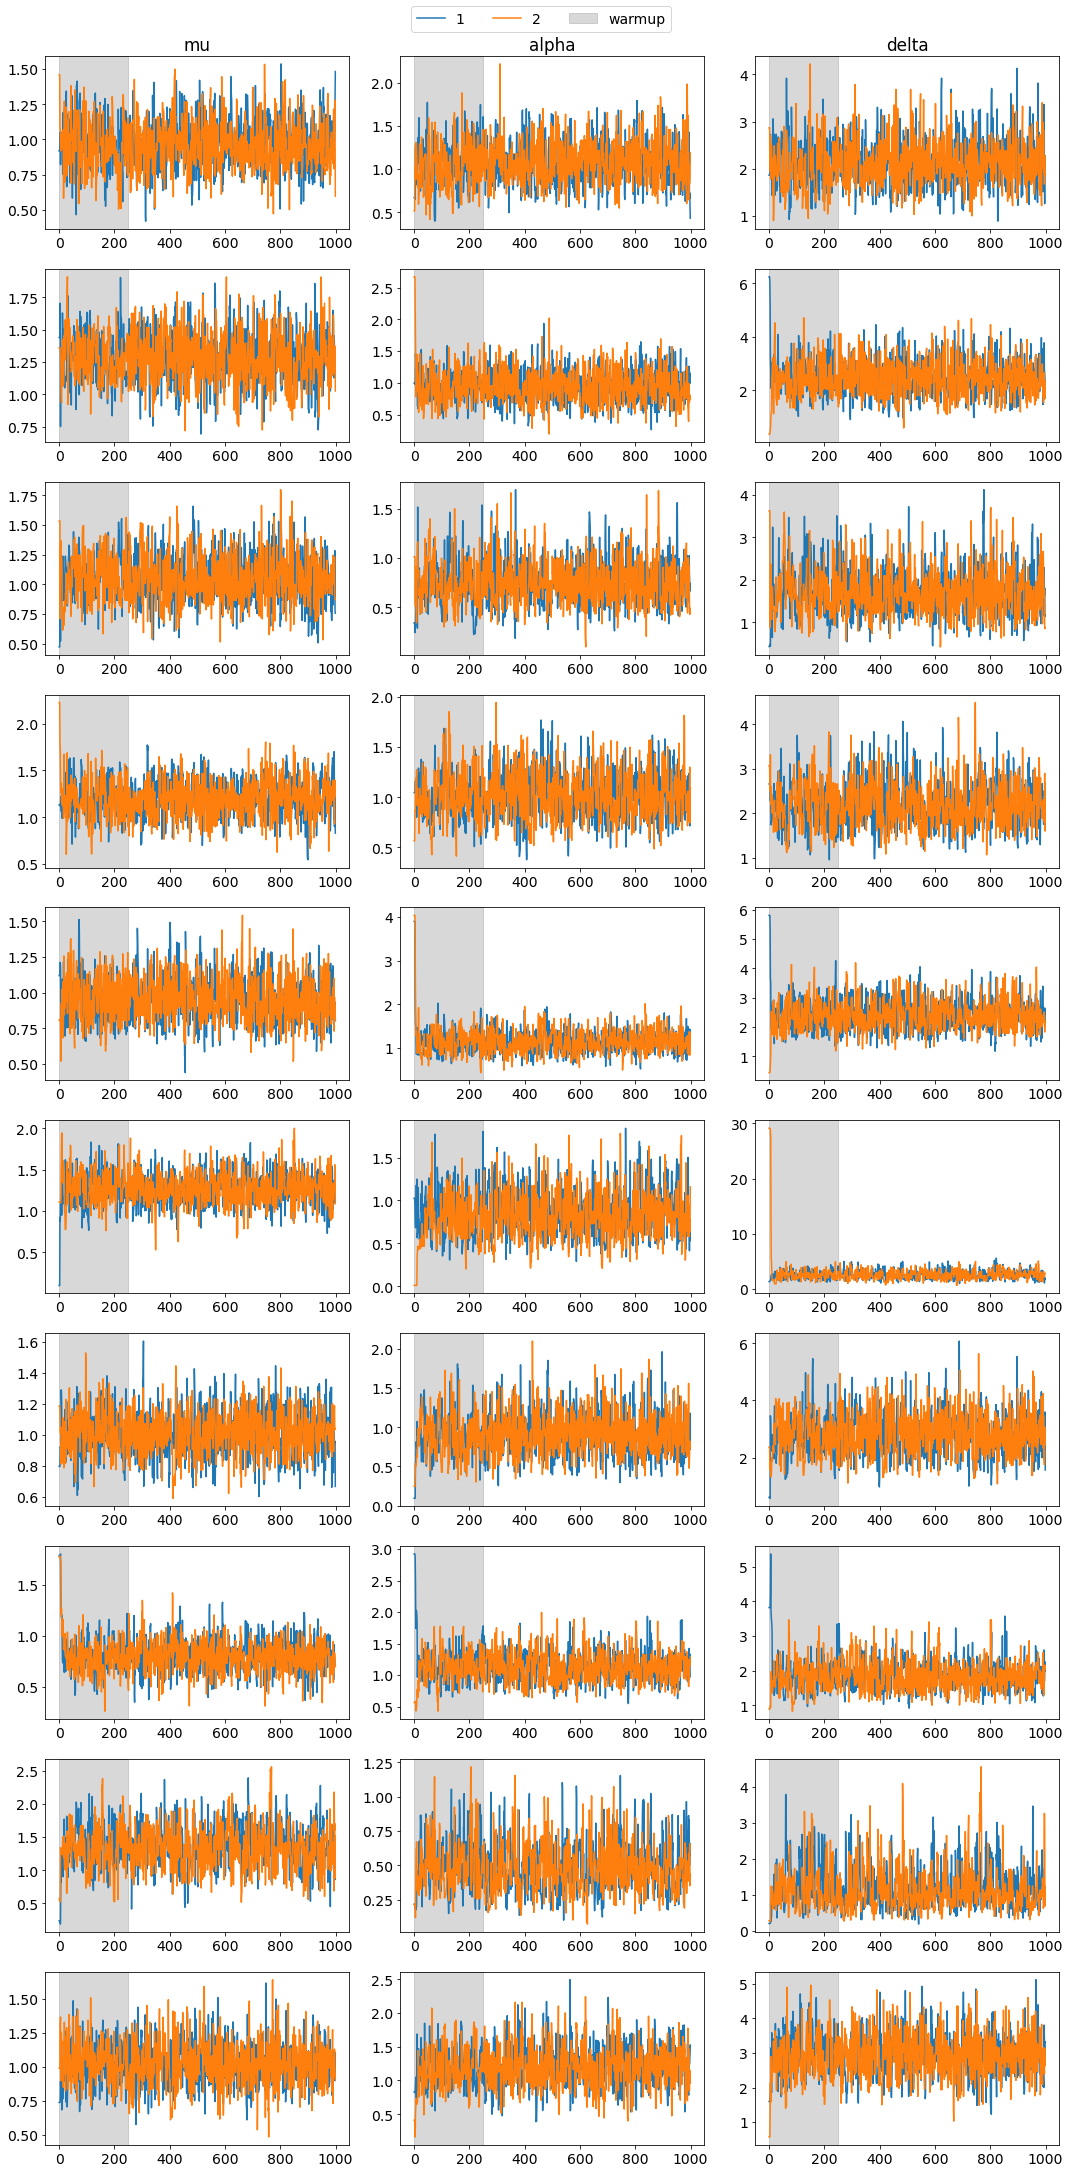

In [390]:
trace_plots(fits, param_strings, warmup=warmup)

In [391]:
def posterior_histograms(fits, params, prior_functions=None):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5*m, 3*n))
    max_x = np.zeros(m)
    max_y = np.zeros(m)
    
    # Plot histograms and KDE plots for posterior distributions
    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data = df[params[j]].values
            hist, bins, _ = axs[i, j].hist(data, density=True, alpha=0.5, bins=30, color='blue')  # Plot histogram
            
            # Suppress specific future warning
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                sns.kdeplot(data, color='blue', ax=axs[i, j], label='Posterior KDE')  # Overlay KDE plot on histogram

            credible_interval = stats.mstats.mquantiles(data, [0.025, 0.975])
            axs[i, j].axvspan(xmin=credible_interval[0], xmax=credible_interval[1], color='green', alpha=0.2, label='95% CI')

            max_x[j] = max(max_x[j], max(data))
            max_y[j] = max(max_y[j], max(hist))
            
            if i == 0:
                axs[i, j].set_title(params[j])  # Set title for the first row of subplots

    # Set the same limits for all subplots
    for i in range(n):
        for j in range(m):
            axs[i, j].set_xlim(0, max_x[j])
            axs[i, j].set_ylim(0, max_y[j])


    # Optionally plot prior density functions
    if prior_functions is not None:
        for j, prior_func in enumerate(prior_functions):
            for i, ax_row in enumerate(axs):
                x_values = np.linspace(0, max_x[j], 1000)  # Generate x values for prior function evaluation
                prior_values = prior_func(x_values)  # Evaluate prior density function
                ax_row[j].plot(x_values, prior_values, color='red', linestyle='--', label='Prior')  # Overlay prior distribution
    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=m)
    
    plt.tight_layout()
    plt.show()

In [392]:
mu_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
alpha_prior = lambda x: norm.pdf(x, loc=1, scale=1**2)
delta_prior = lambda x: norm.pdf(x, loc=2, scale=1**2)

prior_funcs = [mu_prior, alpha_prior, delta_prior]

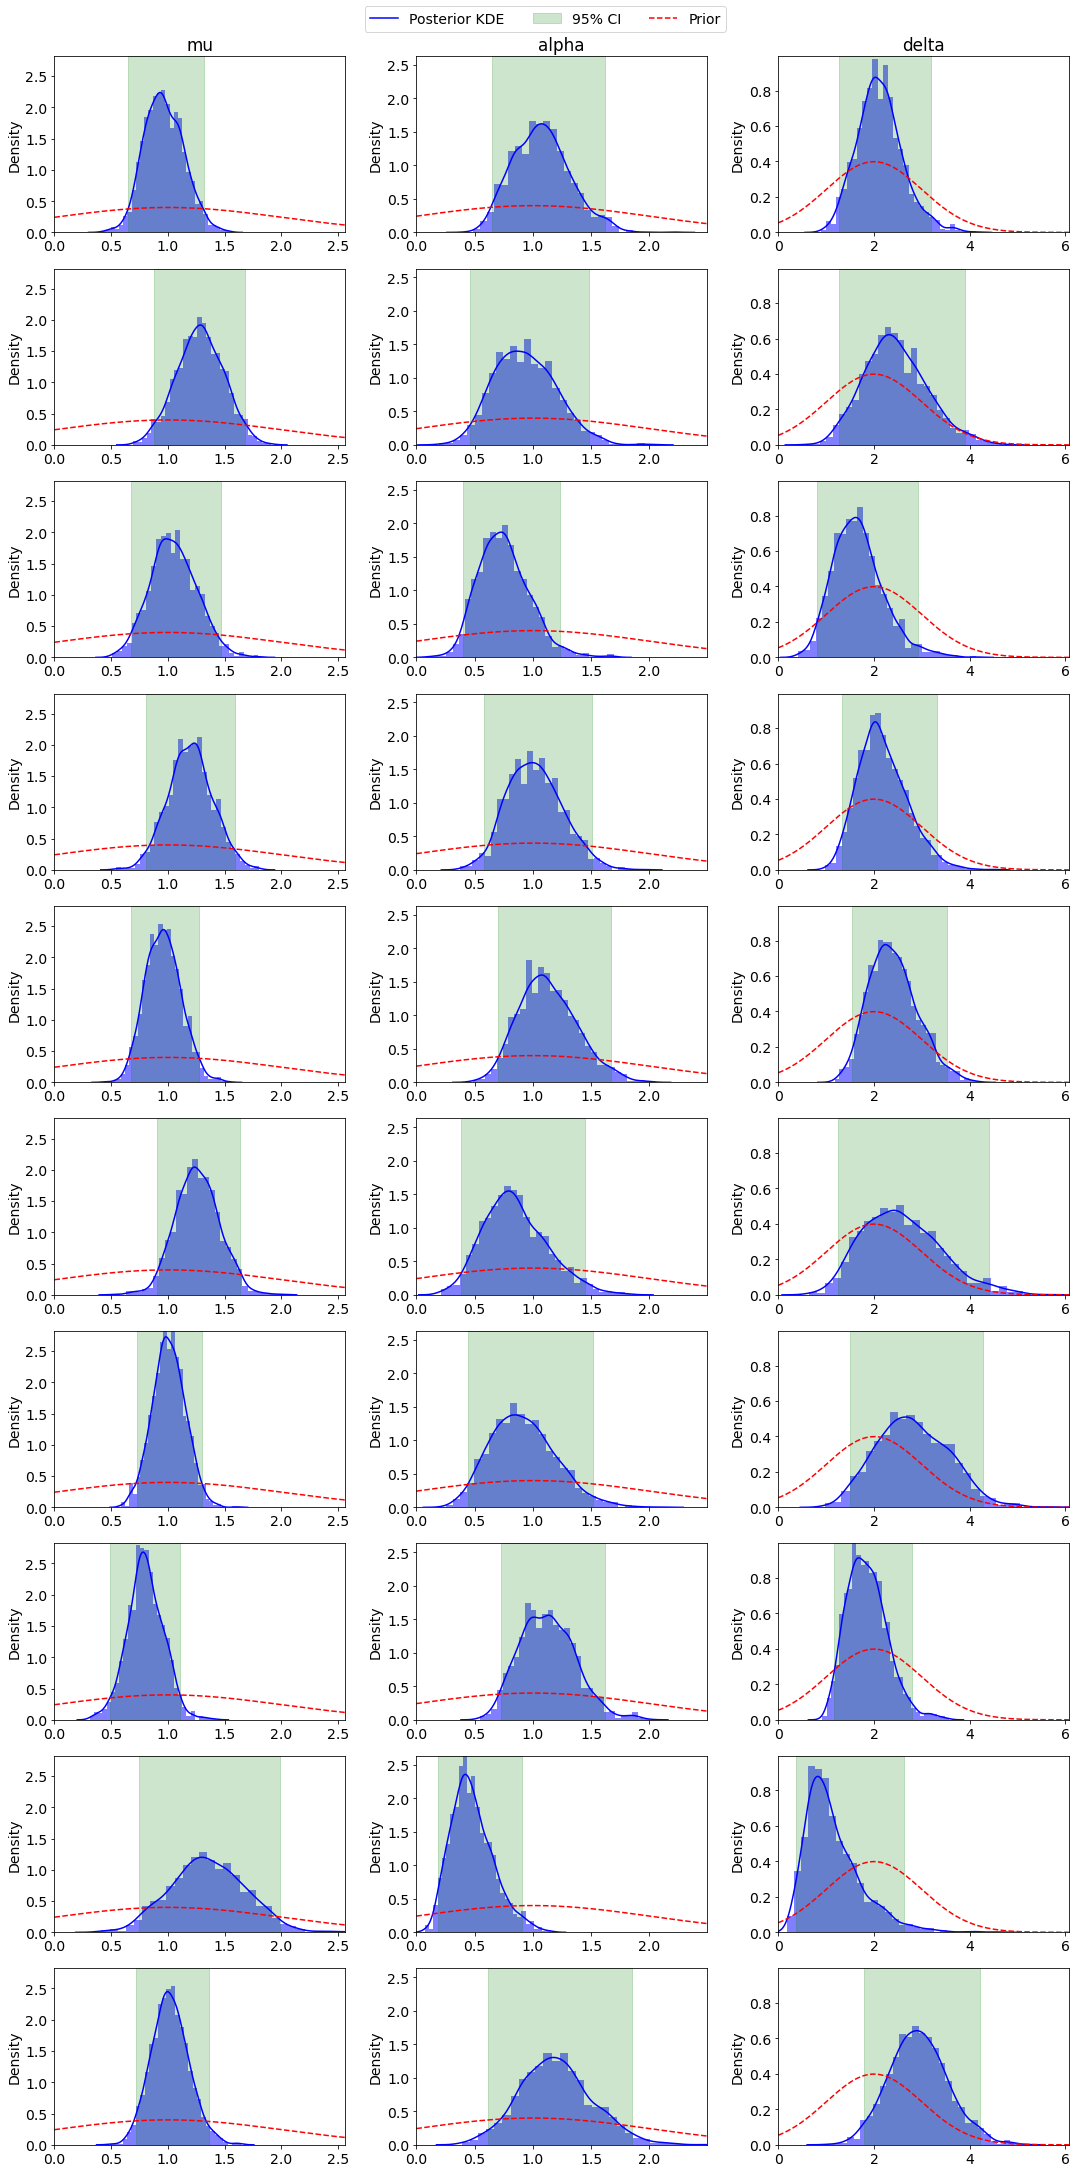

In [393]:
posterior_histograms(fits, param_strings, prior_funcs)

In [394]:
def posterior_kdes_overlaid(fits, params, prior_functions=None):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=1, ncols=m, figsize=(5*m, 3))
    max_x = np.zeros(m)

    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data = df[params[j]].values
            # Suppress specific future warning
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                sns.kdeplot(data, ax=axs[j], alpha=0.5)

            if i == 0:
                axs[j].set_title(params[j])
            max_x[j] = max(max(data), max_x[j])

    # Optionally plot prior density functions
    if prior_functions is not None:
        for j, prior_func in enumerate(prior_functions):
            x_values = np.linspace(0, max_x[j], 1000)  # Generate x values for prior function evaluation
            prior_values = prior_func(x_values)  # Evaluate prior density function
            axs[j].plot(x_values, prior_values, color='red', linestyle='--', label='Prior')  # Overlay prior distribution

        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=m)
    
    plt.tight_layout()
    plt.show()

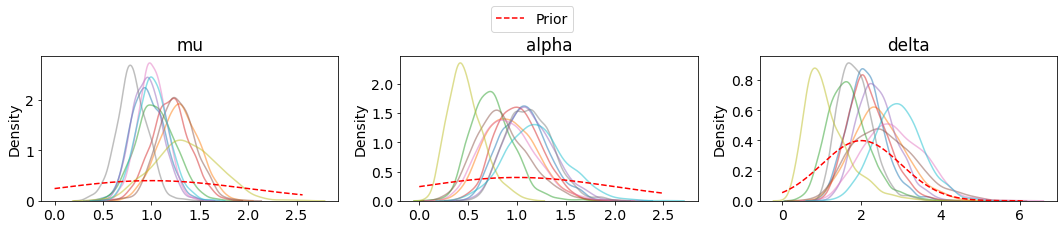

In [395]:
posterior_kdes_overlaid(fits, param_strings, prior_funcs)

In [396]:
def stacked_boxplots(fits, params):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=1, ncols=m, figsize=(6*m, 3))
    max_x = np.zeros(m)
    max_y = np.zeros(m)

    data = np.zeros((n, m, 1500))
    
    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data_temp = df[params[j]].values
            data[i, j] = data_temp
    
    for j in range(m):
        axs[j].boxplot(data[:, j].T, vert=False, positions=np.arange(n))
        axs[j].invert_yaxis()
        axs[j].set_title(params[j])       

    plt.show()

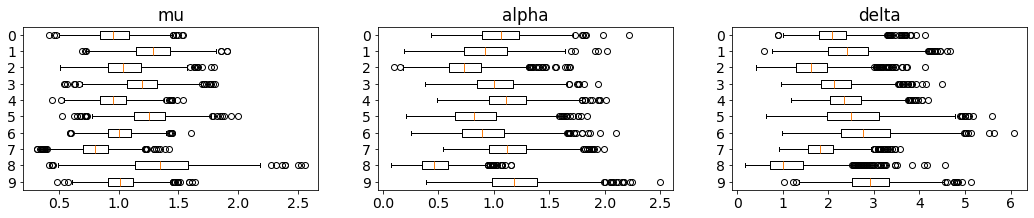

In [397]:
stacked_boxplots(fits, param_strings)

In [398]:
max(fits[6].draws_pd()['delta'])

6.07514

In [399]:
def stacked_credible_intervals(fits, params, true_params, prior_cis=None):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=1, ncols=m, figsize=(6*m, 3))
    max_x = np.zeros(m)
    max_y = np.zeros(m)

    data = np.zeros((n, m, 1500))

    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data = df[params[j]].values

            mean = np.mean(data)

            

            credible_interval = stats.mstats.mquantiles(data, [0.025, 0.975])

            if credible_interval[0] <= true_params[j] <= credible_interval[1]:
                color_temp = 'green'
            else:
                color_temp = 'red'
            

            axs[j].scatter(mean, i, color=color_temp)
            axs[j].plot(credible_interval, [i, i], color=color_temp, linestyle='-', linewidth=2, marker='|')

    for j in range(m):

        if prior_cis:
            axs[j].plot(prior_cis[j], [n, n], color='blue', linestyle='-', linewidth=2, marker='|', label="Prior")

        
        axs[j].axvline(true_params[j], color='black', linestyle='--', label='True parameter value')
        axs[j].invert_yaxis()
        axs[j].set_title(params[j])  # Set title for the first row of subplots

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=m)
    
    plt.tight_layout()
    plt.show()

In [400]:
mu_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
alpha_prior_ci = stats.norm.interval(0.95, loc=1, scale=1**2)
delta_prior_ci = stats.norm.interval(0.95, loc=2, scale=1**2)

prior_cis = [mu_prior_ci, alpha_prior_ci, delta_prior_ci]

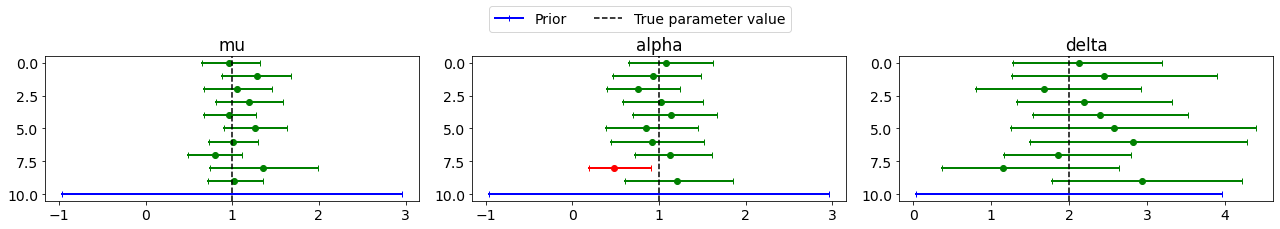

In [401]:
stacked_credible_intervals(fits, param_strings, [1,1,2], prior_cis)

Now we have lots of nice plots and plotting functions.

Let's re run but with inits=0 (in unconstrained space).

In [410]:
warmup=250

# RAN ONCE AND SAVED TO CSVs - NO NEED TO RUN AGAIN
master_seed_stan = 94210775887672546008100330582776109227
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan, pool_size=4)

fits2 = []

for i in range(num_samples):

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(child_seed)

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits=0,
                                save_warmup=True,
                                show_console=True)
    fits2.append(fit)

13:19:34 - cmdstanpy - INFO - CmdStan start processing
13:19:34 - cmdstanpy - INFO - CmdStan done processing
13:19:34 - cmdstanpy - ERROR - CmdStan error: error during processing Operation not permitted


3373845446
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\qth988_c.json
init = 0
random
seed = 3373845446
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2u18q4n2s\simple_exp_hawkes_v2-20240421131934.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)

Rejecting initial value:
Log probability

RuntimeError: Error during sampling:

Command and output files:
RunSet: chains=2, chain_ids=[1, 2], num_processes=1
 cmd (chain 1):
	['C:\\Users\\ethan\\OneDrive - University of Bristol\\Maths\\Year 4\\Project\\hawkes_project\\simple_exp_hawkes_v2.exe', 'id=1', 'random', 'seed=3373845446', 'data', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpsfh_9hts\\qth988_c.json', 'init=0', 'output', 'file=C:\\Users\\ethan\\AppData\\Local\\Temp\\tmpsfh_9hts\\simple_exp_hawkes_v2u18q4n2s\\simple_exp_hawkes_v2-20240421131934.csv', 'method=sample', 'num_samples=750', 'num_warmup=250', 'save_warmup=1', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=2']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2u18q4n2s\simple_exp_hawkes_v2-20240421131934_1.csv
 console_msgs (if any):
	C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2u18q4n2s\simple_exp_hawkes_v2-20240421131934-stdout.txt

This didn't work fully. Options are to leave as randomly initialised or fix (for example) as all 0.5

In [411]:
stan_file = os.path.join('.', 'simple_exp_hawkes_v2_nonneg_mu.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

15:37:22 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\simple_exp_hawkes_v2_nonneg_mu.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2_nonneg_mu.exe
15:37:41 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2_nonneg_mu.exe


In [412]:
warmup=250

# RAN ONCE AND SAVED TO CSVs - NO NEED TO RUN AGAIN
master_seed_stan = 94210775887672546008100330582776109227
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan, pool_size=4)

fits2 = []

for i in range(num_samples):

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(child_seed)

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits=0,
                                save_warmup=True,
                                show_console=True)
    fits2.append(fit)

15:38:00 - cmdstanpy - INFO - CmdStan start processing


3373845446
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\ngp0tyzq.json
init = 0
random
seed = 3373845446
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_mu9rvwcp0y\simple_exp_hawkes_v2_nonneg_mu-20240421153800.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:38:25 - cmdstanpy - INFO - CmdStan done processing
15:38:25 - cmdstanpy - INFO - CmdStan start processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 7.071 seconds (Warm-up)
18.244 seconds (Sampling)
25.315 seconds (Total)























































































































1790003987
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\axjil1ih.json
init = 0
random
seed = 1790003987
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonn

15:38:57 - cmdstanpy - INFO - CmdStan done processing
15:38:57 - cmdstanpy - INFO - CmdStan start processing


Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 8.198 seconds (Warm-up)
23.832 seconds (Sampling)
32.03 seconds (Total)


































































































































875708943
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\2i0fnjyh.json
init = 0
random
seed = 875708943
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes

15:40:01 - cmdstanpy - INFO - CmdStan done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 7.745 seconds (Warm-up)
55.844 seconds (Sampling)
63.589 seconds (Total)




















































































15:40:01 - cmdstanpy - INFO - CmdStan start processing


3419739734
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\qe2dw0yg.json
init = 0
random
seed = 3419739734
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_munjlxl_77\simple_exp_hawkes_v2_nonneg_mu-20240421154001.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:42:02 - cmdstanpy - INFO - CmdStan done processing


Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 22.768 seconds (Warm-up)
98.394 seconds (Sampling)
121.162 seconds (Total)



































































































































15:42:03 - cmdstanpy - INFO - CmdStan start processing


2711842920
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\ddzxsmk0.json
init = 0
random
seed = 2711842920
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_mumgl5ji7t\simple_exp_hawkes_v2_nonneg_mu-20240421154203.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:42:33 - cmdstanpy - INFO - CmdStan done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 4.628 seconds (Warm-up)
25.849 seconds (Sampling)
30.477 seconds (Total)



































































15:42:33 - cmdstanpy - INFO - CmdStan start processing


3537363581
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\70oqwtif.json
init = 0
random
seed = 3537363581
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_muarr0i2ra\simple_exp_hawkes_v2_nonneg_mu-20240421154233.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:43:56 - cmdstanpy - INFO - CmdStan done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 7.42 seconds (Warm-up)
75.282 seconds (Sampling)
82.702 seconds (Total)





































































































458812910


15:43:56 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\r7tfg2ii.json
init = 0
random
seed = 458812910
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_mu_330bhie\simple_exp_hawkes_v2_nonneg_mu-20240421154356.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation took 0.0011

15:44:23 - cmdstanpy - INFO - CmdStan done processing
15:44:24 - cmdstanpy - INFO - CmdStan start processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 3.262 seconds (Warm-up)
23.846 seconds (Sampling)
27.108 seconds (Total)






























































4224282303
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\y4dq14zv.json
init = 0
random
seed = 4224282303
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_musash2_43\simple_exp_hawkes_v2_nonneg_mu-202404211544

15:46:04 - cmdstanpy - INFO - CmdStan done processing


Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 8.259 seconds (Warm-up)
91.915 seconds (Sampling)
100.174 seconds (Total)






































































15:46:04 - cmdstanpy - INFO - CmdStan start processing


3159087222
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\c1qy93pi.json
init = 0
random
seed = 3159087222
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_mut_fiytsv\simple_exp_hawkes_v2_nonneg_mu-20240421154604.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:49:03 - cmdstanpy - INFO - CmdStan done processing


Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 26.133 seconds (Warm-up)
153.057 seconds (Sampling)
179.19 seconds (Total)















































































15:49:04 - cmdstanpy - INFO - CmdStan start processing


2707504314
method = sample (Default)
sample
num_samples = 750
num_warmup = 250
save_warmup = 1
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = 0 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 2
id = 1 (Default)
data
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\yni50po5.json
init = 0
random
seed = 2707504314
output
file = C:\Users\ethan\AppData\Local\Temp\tmpsfh_9hts\simple_exp_hawkes_v2_nonneg_muticaeek9\simple_exp_hawkes_v2_nonneg_mu-20240421154904.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = 0 (Default)
num_threads = 2 (Default)


Gradient evaluation

15:49:22 - cmdstanpy - INFO - CmdStan done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)

Elapsed Time: 4.457 seconds (Warm-up)
13.961 seconds (Sampling)
18.418 seconds (Total)















































































































































































































































































































































































In [415]:
def trace_plots(fits, params, warmup=None, chains=2):
    n = len(fits)
    m = len(params)
    max_y = np.zeros(m)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5*m, 3*n))
    for i in range(n):
        df = fits[i].draws_pd(inc_warmup=(warmup is not None))
        for j in range(m):
            for k in range(1, chains+1):
                axs[i, j].plot(df[df['chain__']==k][params[j]].values, label=k)
            if warmup:
                axs[i, j].axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
            #axs[i, j].legend()
            max_y[j] = max(max(df[df['chain__']==k][params[j]].values), max_y[j])
            if i==0:
                axs[i, j].set_title(params[j])

    for i in range(n):
        for j in range(m):
            axs[i, j].set_ylim(0, max_y[j])


    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=chains+1)
    
    plt.tight_layout()
    plt.show()

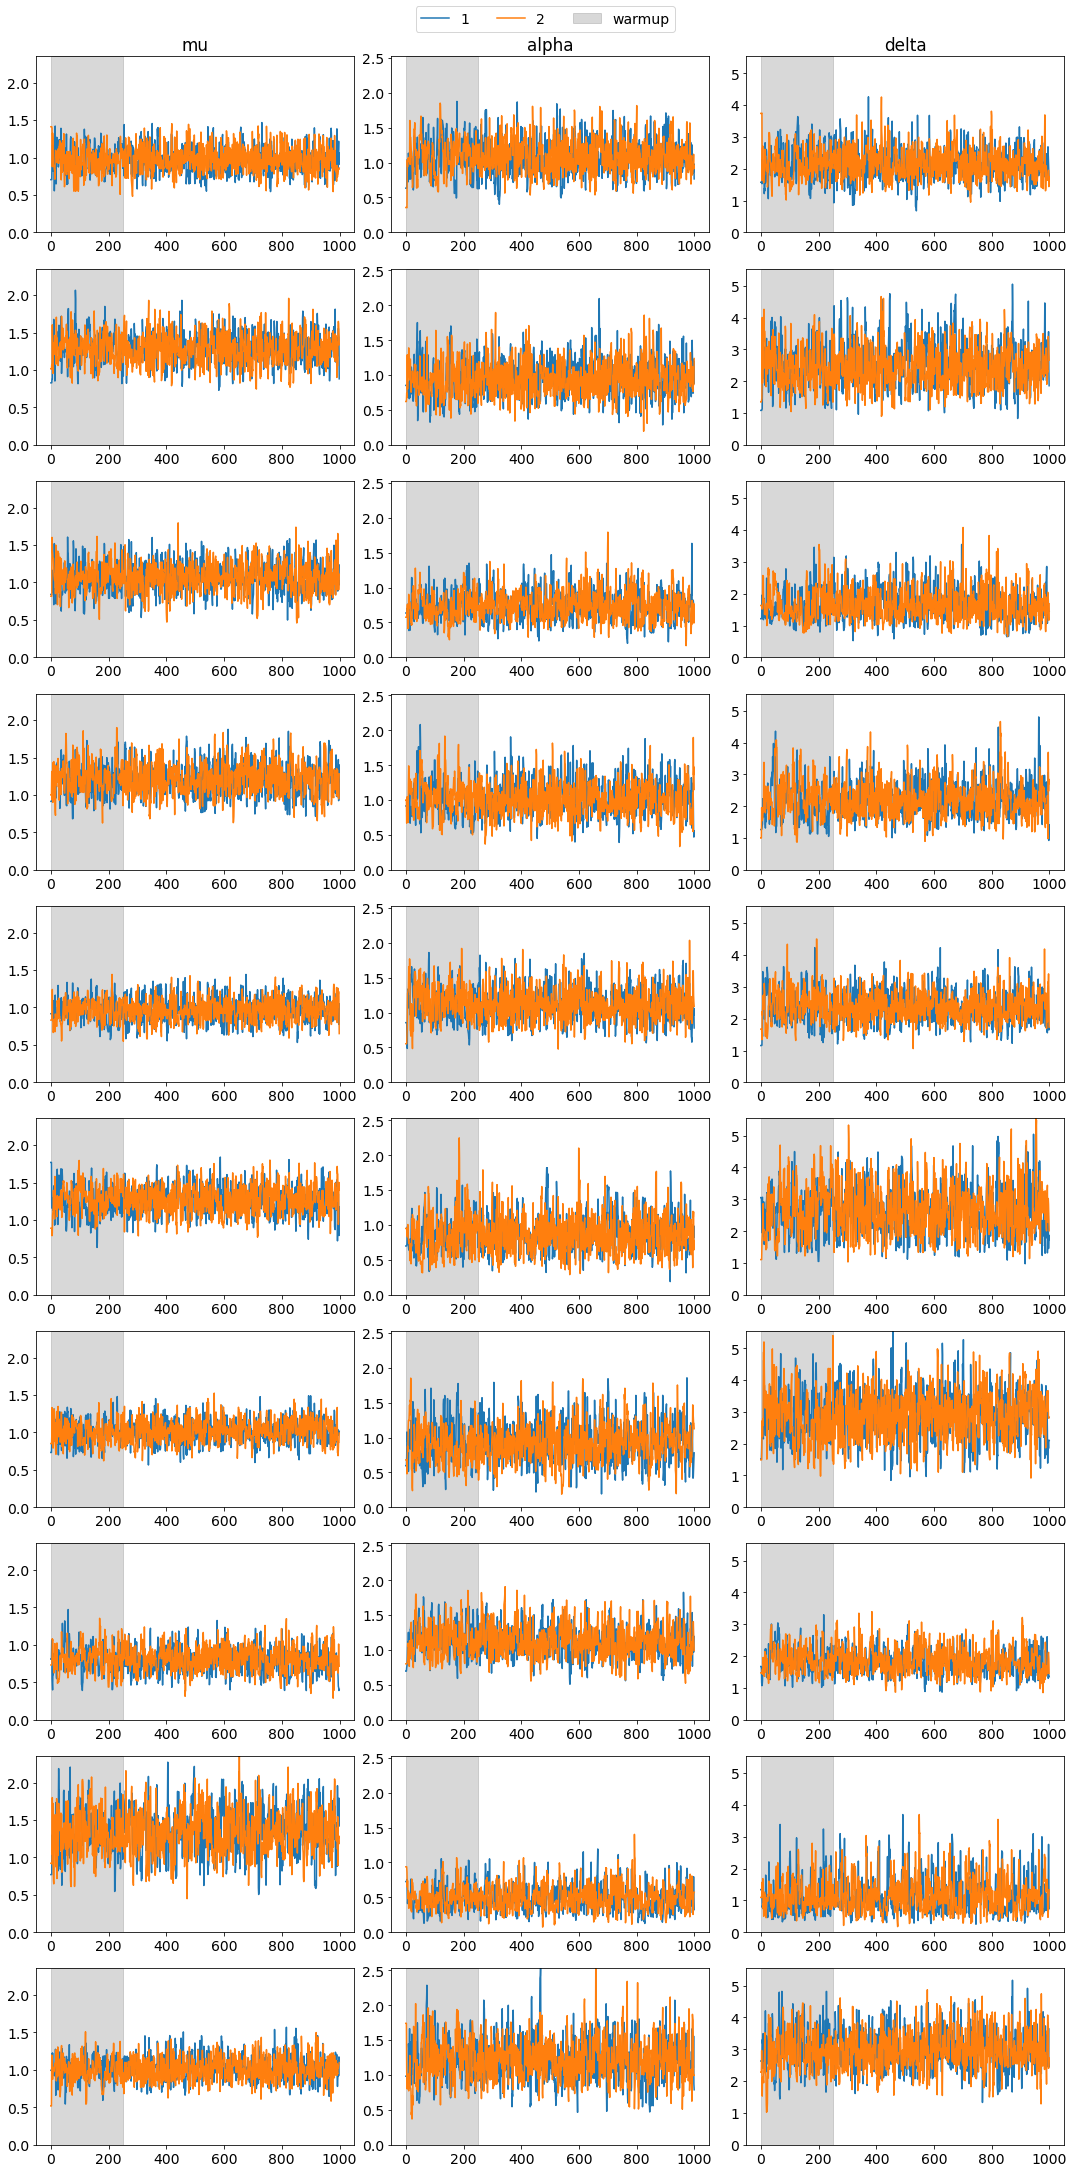

In [416]:
trace_plots(fits2, param_strings, warmup=warmup)

In [431]:
fits2[3].draws_pd(inc_warmup=True).head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-27.2424,1.000000e+00,0.062500,3.0,15.0,0.0,41.0680,0.914587,0.914951,1.26638,-27.0240
1,1.0,2.0,2.0,-27.2424,0.000000e+00,14.385500,0.0,1.0,1.0,28.7138,0.914587,0.914951,1.26638,-27.0240
2,1.0,3.0,3.0,-27.2424,0.000000e+00,2.431170,0.0,1.0,1.0,30.1269,0.914587,0.914951,1.26638,-27.0240
3,1.0,4.0,4.0,-27.2424,5.504500e-35,0.239791,1.0,2.0,1.0,34.0487,0.914587,0.914951,1.26638,-27.0240
4,1.0,5.0,5.0,-25.9943,1.000000e+00,0.018627,3.0,7.0,0.0,27.3162,0.926562,0.880262,1.30634,-25.8073


In [432]:
warmup=250

# RAN ONCE AND SAVED TO CSVs - NO NEED TO RUN AGAIN
master_seed_stan = 94210775887672546008100330582776109227
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan, pool_size=4)

fits3 = []

for i in range(num_samples):

    child_seed_stan = seed_seq_master_stan.spawn(1)[0]

    # Create a random number generator using the seed
    rng = np.random.default_rng(child_seed_stan)
    
    # Generate random integers less than 2**32 - 1
    child_seed = rng.integers(2**32 - 1)
    print(child_seed)

    fit = model_compiled.sample(data=data_list[i],
                                seed=child_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True)
    fits3.append(fit)

16:13:12 - cmdstanpy - INFO - CmdStan start processing


3373845446


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

16:13:39 - cmdstanpy - INFO - CmdStan done processing.
16:13:39 - cmdstanpy - INFO - CmdStan start processing



1790003987


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

16:15:24 - cmdstanpy - INFO - CmdStan done processing.
16:15:25 - cmdstanpy - INFO - CmdStan start processing



875708943


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

KeyboardInterrupt: 

In [436]:
fits3[0].draws_pd(inc_warmup=True).head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,alpha,delta,hawkes_log_likelihood
0,1.0,1.0,1.0,-49.6612,1.000000,0.125000,1.0,1.0,0.0,55.4002,0.704651,0.633252,1.57380,-49.1060
1,1.0,2.0,2.0,-49.6612,0.000000,14.385500,0.0,1.0,1.0,49.7884,0.704651,0.633252,1.57380,-49.1060
2,1.0,3.0,3.0,-49.6612,0.000000,2.431170,0.0,1.0,1.0,53.6430,0.704651,0.633252,1.57380,-49.1060
3,1.0,4.0,4.0,-49.6612,0.000000,0.239791,0.0,1.0,1.0,51.3361,0.704651,0.633252,1.57380,-49.1060
4,1.0,5.0,5.0,-42.7089,0.999193,0.018627,4.0,15.0,0.0,50.9267,0.886356,0.893503,1.52874,-42.7769


In [449]:
fits3[1].method_variables()

{'lp__': array([[-52.6794, -47.5111],
        [-52.6794, -47.5111],
        [-52.6794, -47.5111],
        ...,
        [-46.6478, -46.4495],
        [-45.3991, -45.6237],
        [-48.0728, -46.0539]]),
 'accept_stat__': array([[1.      , 0.333405],
        [0.      , 0.      ],
        [0.      , 0.      ],
        ...,
        [0.624159, 1.      ],
        [1.      , 0.97252 ],
        [0.91219 , 0.923953]]),
 'stepsize__': array([[ 0.0625  ,  0.125   ],
        [14.3855  ,  4.28119 ],
        [ 2.43117 ,  0.505196],
        ...,
        [ 0.326714,  0.291952],
        [ 0.326714,  0.291952],
        [ 0.326714,  0.291952]]),
 'treedepth__': array([[2., 2.],
        [0., 0.],
        [0., 0.],
        ...,
        [2., 3.],
        [4., 2.],
        [3., 3.]]),
 'n_leapfrog__': array([[ 3.,  3.],
        [ 1.,  1.],
        [ 1.,  1.],
        ...,
        [ 7.,  7.],
        [15.,  7.],
        [11., 11.]]),
 'divergent__': array([[0., 0.],
        [1., 1.],
        [1., 1.],
      

In [451]:
fits3[0].method_variables()

{'lp__': array([[-49.6612, -59.6285],
        [-49.6612, -59.6285],
        [-49.6612, -59.6285],
        ...,
        [-42.8579, -41.8789],
        [-42.0596, -43.3661],
        [-42.8657, -42.0773]]),
 'accept_stat__': array([[1.      , 1.      ],
        [0.      , 0.      ],
        [0.      , 0.      ],
        ...,
        [0.96041 , 0.999374],
        [0.987413, 0.888145],
        [0.987546, 0.881237]]),
 'stepsize__': array([[ 0.125   ,  0.125   ],
        [14.3855  , 14.3855  ],
        [ 2.43117 ,  2.43117 ],
        ...,
        [ 0.333552,  0.378498],
        [ 0.333552,  0.378498],
        [ 0.333552,  0.378498]]),
 'treedepth__': array([[1., 3.],
        [0., 0.],
        [0., 0.],
        ...,
        [1., 3.],
        [3., 3.],
        [3., 2.]]),
 'n_leapfrog__': array([[ 1.,  7.],
        [ 1.,  1.],
        [ 1.,  1.],
        ...,
        [ 3.,  7.],
        [11.,  7.],
        [ 7.,  7.]]),
 'divergent__': array([[0., 0.],
        [1., 1.],
        [1., 1.],
      